In [1]:
import numpy as np
from scipy.special import sph_harm
import pyvista as pv
# Switch off interactive mode
pv.set_jupyter_backend('static')
pv.start_xvfb()

Pyvista is a useful 3D plotting module that, unlike older myavi, supports overlapping surfaces properly

In [2]:
def Ylm(l, m, T, P):
    return sph_harm(m, l, T, P)


tiny = 1e-10


def cart_to_spherical(X, Y, Z):
    R = np.sqrt(X**2 + Y**2 + Z**2)
    T = np.arctan2(Y, X) # N.B. standard trig flunction causes problems here
    P = np.arccos(Z/(R + tiny))
    return R, T, P


def make_surface(orb, percentile, xoff=0, yoff=0,  reverse=False):
    X, Y, Z = np.mgrid[-1:1:.02, -1:1:.02, -1:1:.02]
    X += xoff
    Y += yoff
    R, T, P = cart_to_spherical(X - xoff, Y - yoff, Z)
    R[R < tiny] = tiny

    if orb == 'x2y2':
        f = 1/np.sqrt(2)*(Ylm(2, 2, T, P) +
                          Ylm(2, -2, T, P))/R**2
    elif orb == 'z2r2':
        f = Ylm(2, 0, T, P)/R**2
    elif orb == 'px':
        f = (Ylm(1, -1, T, P) - Ylm(1, 1, T, P))/R**2
    elif orb == 'py':
        f = 1j*(Ylm(1, -1, T, P) + Ylm(1, 1, T, P))/R**2

    V = f.real + f.imag
    grid = pv.StructuredGrid(X, Y, Z)
    grid['vol'] = V.flatten(order='F')
    threshold = np.percentile(np.abs(V), percentile)

    if 'orb' == 'z2r2':
        return grid.contour([threshold])

    if reverse is False:
        s_p = grid.contour([threshold])
        s_n = grid.contour([-threshold])
    else:
        s_p = grid.contour([-threshold])
        s_n = grid.contour([threshold])
    return s_p, s_n

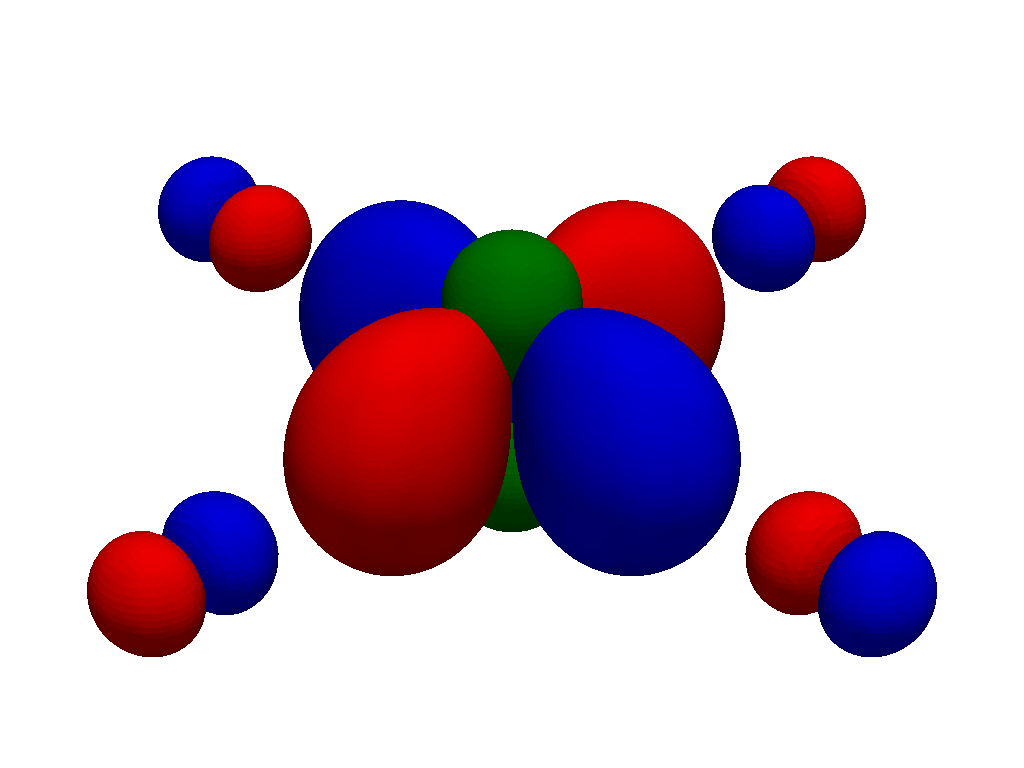

In [3]:
pl = pv.Plotter()
s_p, s_n = make_surface('x2y2', 90)
pl.add_mesh(s_p, color='red')
pl.add_mesh(s_n, color='blue')

psize = 99.5
s_p, s_n = make_surface('px', psize, xoff=1.3)
pl.add_mesh(s_p, color='red')
pl.add_mesh(s_n, color='blue')

s_p, s_n = make_surface('px', psize, xoff=-1.3, reverse=True)
pl.add_mesh(s_p, color='red')
pl.add_mesh(s_n, color='blue')

s_p, s_n = make_surface('py', psize, yoff=1.3, reverse=True)
pl.add_mesh(s_p, color='red')
pl.add_mesh(s_n, color='blue')

s_p, s_n = make_surface('py', psize, yoff=-1.3)
pl.add_mesh(s_p, color='red')
pl.add_mesh(s_n, color='blue')

s_p, s_n = make_surface('z2r2', 98)
pl.add_mesh(s_p, color='green')
pl.camera.zoom(2.0)
pl.set_background('white')
_ = pl.screenshot('ex_22_multi_orbitals.png')
pl.show()

In [4]:
from PIL import Image

im = Image.open(r'ex_22_multi_orbitals.png')
im_rbg = im.convert('RGB')
im_rbg.save(r'ex_22_multi_orbitals.pdf')